- https://jaeyong-song.github.io/posts/GNN_Pytorch_Basic/
- https://yunny-p.tistory.com/65

In [1]:
import torch
print('TORCH Version :', torch.__version__)
print('TORCH CUDA Version :', torch.version.cuda)

c:\Users\yang.yoonjeong\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TORCH Version : 1.12.0
TORCH CUDA Version : 11.6


In [2]:
# try: 
#     import torch_geometric
# except ModuleNotFoundError:
#     TORCH = torch.__version__.split('+')[0]
#     CUDA = 'cu' + torch.version.cuda.replace('.','')
#     !pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
#     !pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
#     !pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
#     !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
#     !pip install torch-geometric

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import sklearn.metrics as metrics

In [4]:
BATCH_SIZE = 32

## transformations
transform = transforms.Compose([transforms.ToTensor()])

## download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
# 데이터로더를 활용하면 사이즈별로 나눠주고 iterator 형식으로 저장하며, 뒤에서 보겠지만, (data, label) 와 같은 형식으로 건네줍니다.
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

## download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

In [5]:
# MNIST의 6만개 데이터셋과 일치합니다
print(len(trainset))
# 28x28을 출력하고 싶다면 아래를 실행해보시면 됩니다.
# print(trainset[10])

60000


In [6]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        # 28x28x1 => 26x26x32
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.d1 = nn.Linear(26 * 26 * 32, 128)
        self.d2 = nn.Linear(128, 10)

    def forward(self, x):
        # 32x1x28x28 => 32x32x26x26
        x = self.conv1(x)
        x = F.relu(x)

        # flatten => 32 x (32*26*26)
        x = x.flatten(start_dim = 1)
        #x = x.view(32, -1)

        # 32 x (32*26*26) => 32x128
        x = self.d1(x)
        x = F.relu(x)

        # logits => 32x10
        logits = self.d2(x)
        out = F.softmax(logits, dim=1)
        return out

In [7]:
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'
    
print(device)

cuda:0


In [8]:
import numpy as np
a = np.array([[1,2],[3,4]])
b = np.ones((2,2))

ta = torch.tensor(a, dtype=float).to(device)
tb = torch.ones(2,2, dtype=float).to(device)

print(ta)
print(ta @ tb) # matmul 함수와 동일합니다.

tensor([[1., 2.],
        [3., 4.]], device='cuda:0', dtype=torch.float64)
tensor([[3., 3.],
        [7., 7.]], device='cuda:0', dtype=torch.float64)


In [9]:
learning_rate = 0.001
num_epochs = 1 # 실습이니 1 에폭만 돌립니다... 한 5에폭 돌리면 98-99퍼 accuracy 나옵니다

if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

model = MyModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    ## training step
    # 앞에서 설명한 바와 마찬가지로 (data, label) 형태로 배치사이즈에 맞게 반환해줍니다.
    for i, (images, labels) in enumerate(trainloader):
        
        # in memory의 데이터를 gpu로 올려야 연산이 가능합니다.
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images) # 모델에 데이터를 통과시켜서 계산합니다
        loss = criterion(logits, labels) # 계산한 logit(CELoss 입니다...)을 loss함수에 넣어서 계산합니다.
        # 이부분에서 왜 loss를 이용했는데 optimizer.step()을 하면 업데이트 되는지 궁금해 하시는 분들이 많습니다.
        # 파이토치 코드를 보고 모델을 실제로 디버깅 해보시면, (디버깅 모드에서 model을 print해서 보시면 됩니다.)
        # loss는 파이토치 모델 내의 gradient 변수에 값을 저장합니다.
        # 그런데, optimizer는 model.parameters()를 통해서 모델과 연결되어있습니다.
        # 따라서 gradient update와 parameter update가 가능합니다.
        # (CS224w 강의에서 애매하게 답변이 나왔는데, 정확한 분석은 위와 같습니다.)
        optimizer.zero_grad() # 중요한 부분입니다: gradient 초기화를 해주지 않으면 이전 gradient와 accum 합니다. (순서가 중요)
        loss.backward() # 계산한 loss 함수를 이용해서 미분값을 계산합니다

        ## update model params
        optimizer.step() # 계산한 미분값을 이용해서 파라미터를 업데이트 합니다.

        train_running_loss += loss.detach().item()
        train_acc += (torch.argmax(logits, 1).flatten() == labels).type(torch.float).mean().item()
    
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i))

Epoch: 0 | Loss: 1.6466 | Train Accuracy: 0.82


In [11]:
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += (torch.argmax(outputs, 1).flatten() == labels).type(torch.float).mean().item()
    preds = torch.argmax(outputs, 1).flatten().cpu().numpy()
        
print('Test Accuracy: %.2f'%(test_acc/i))

Test Accuracy: 0.97


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_sparse import SparseTensor

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

import time
from datetime import datetime

import networkx as nx
import numpy as np
import torch
import torch.optim as optim

# 실습용 그래프 데이터와 이를 사용하기 위한 데이터로더입니다.
from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.transforms as T

# 텐서보드를 이용해서 시각화하기 위해 필요합니다.
# from tensorboardX import SummaryWriter # <-- 원래 코드
from torch.utils.tensorboard import SummaryWriter  # <-- 이걸로 수정
# 임베딩의 시각화를 위해서 필요합니다.
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [16]:
class GNNStack(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, task='node'):
        super(GNNStack, self).__init__()
        self.task = task
        # 모듈리스트를 이용해서 레이어 추가
        self.convs = nn.ModuleList()
        self.convs.append(self.build_conv_model(input_dim, hidden_dim))
        # 정규화 레이어 추가
        self.lns = nn.ModuleList()
        self.lns.append(nn.LayerNorm(hidden_dim))
        self.lns.append(nn.LayerNorm(hidden_dim))
        # 총 3개 레이어 이므로 2개 추가
        for l in range(2):
            self.convs.append(self.build_conv_model(hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(0.25), 
            nn.Linear(hidden_dim, output_dim))
        if not (self.task == 'node' or self.task == 'graph'):
            raise RuntimeError('Unknown task.')

        self.dropout = 0.25
        self.num_layers = 3

    def build_conv_model(self, input_dim, hidden_dim):
        # refer to pytorch geometric nn module for different implementation of GNNs.
        if self.task == 'node':
            # 원래는 GCNConv를 이용하지만, 아래에서 구현해본 결과를 살펴보기 위해서 해볼 것!
            return pyg_nn.GCNConv(input_dim, hidden_dim)
            #return CustomConv(input_dim, hidden_dim)
        else:
            return pyg_nn.GINConv(nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                  nn.ReLU(), nn.Linear(hidden_dim, hidden_dim)))

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        if data.num_node_features == 0:
          x = torch.ones(data.num_nodes, 1)
        
        # 각 레이어 사이에는 ReLU와 오버피팅을 막기 위한 드롭아웃 추가
        # 그러나 마지막 레이어에는 추가하지 말아야함... 성능상 이유
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            emb = x
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            if not i == self.num_layers - 1:
                x = self.lns[i](x)
        
        # 그래프 분류의 경우에는 mean pool 진행해야함
        if self.task == 'graph':
            x = pyg_nn.global_mean_pool(x, batch)
        
        # 분류를 위한 fc 통과
        x = self.post_mp(x)

        return emb, F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

In [17]:
class CustomConv(pyg_nn.MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(CustomConv, self).__init__(aggr='add')  # "Add" aggregation.
        self.lin = nn.Linear(in_channels, out_channels)
        
#         # 방법2를 해보기 위해서 추가함.
#         self.lin_self = nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]
        
        # 방법 1 : self loop를 메소드로 추가
        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = pyg_utils.add_self_loops(edge_index, num_nodes=x.size(0))
        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x)
        
#         # 방법 2: 수동으로 Identity Matrix 더해줌
#         # Step 1: Remove self-loops from the adjacency matrix. (add later)
#         edge_index, _ = pyg_utils.remove_self_loops(edge_index)
#         # Step 2: Linearly transform node feature matrix.
#         self_x = self.lin_self(x)
#         return self_x + self.propagate(edge_index, size=(x.size(0), x.size(0)), x=self.lin(x))

    def message(self, x_j, edge_index, size):
        # Compute messages
        # x_j has shape [E, out_channels]

        # Step 3: Compute normalization.
        # Step 4: Normalize node features.
        # Step 4-5: Start propagating messages.
        row, col = edge_index
        deg = pyg_utils.degree(row, size[0], dtype=x_j.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        return norm.view(-1, 1) * x_j

    def update(self, aggr_out):
        # aggr_out has shape [N, out_channels]
        
        return aggr_out

In [18]:
class GNNCustomStack(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, task='node'):
        super(GNNCustomStack, self).__init__()
        self.task = task
        # 모듈리스트를 이용해서 레이어 추가
        self.convs = nn.ModuleList()
        self.convs.append(self.build_conv_model(input_dim, hidden_dim))
        # 정규화 레이어 추가
        self.lns = nn.ModuleList()
        self.lns.append(nn.LayerNorm(hidden_dim))
        self.lns.append(nn.LayerNorm(hidden_dim))
        # 총 3개 레이어 이므로 2개 추가
        for l in range(2):
            self.convs.append(self.build_conv_model(hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(0.25), 
            nn.Linear(hidden_dim, output_dim))
        if not (self.task == 'node' or self.task == 'graph'):
            raise RuntimeError('Unknown task.')

        self.dropout = 0.25
        self.num_layers = 3

    def build_conv_model(self, input_dim, hidden_dim):
        # refer to pytorch geometric nn module for different implementation of GNNs.
        if self.task == 'node':
            # 원래는 GCNConv를 이용하지만, 아래에서 구현해본 결과를 살펴보기 위해서 해볼 것!
            #return pyg_nn.GCNConv(input_dim, hidden_dim)
            return CustomConv(input_dim, hidden_dim)
        else:
            return pyg_nn.GINConv(nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                  nn.ReLU(), nn.Linear(hidden_dim, hidden_dim)))

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        if data.num_node_features == 0:
          x = torch.ones(data.num_nodes, 1)
        
        # 각 레이어 사이에는 ReLU와 오버피팅을 막기 위한 드롭아웃 추가
        # 그러나 마지막 레이어에는 추가하지 말아야함... 성능상 이유
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            emb = x
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            if not i == self.num_layers - 1:
                x = self.lns[i](x)
        
        # 그래프 분류의 경우에는 mean pool 진행해야함
        if self.task == 'graph':
            x = pyg_nn.global_mean_pool(x, batch)
        
        # 분류를 위한 fc 통과
        x = self.post_mp(x)

        return emb, F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

In [19]:
def train(dataset, task, writer):
    if task == 'graph':
        # 그래프 분류의 경우에는 단순하게 나누면 됨.
        data_size = len(dataset)
        loader = DataLoader(dataset[:int(data_size * 0.8)], batch_size=64, shuffle=True)
        test_loader = DataLoader(dataset[int(data_size * 0.8):], batch_size=64, shuffle=True)
    else:
        # 노드 분류의 경우에는 batch.train_mask 활용할 것
        test_loader = loader = DataLoader(dataset, batch_size=64, shuffle=True)

    # build model
    # GNNStack 대신 직접 구현한 GCN 모델 활용해볼 것
    # GCNCustomStack(이 경우에 결과가 비슷한가??)
    model = GNNStack(max(dataset.num_node_features, 1), 32, dataset.num_classes, task=task)
    opt = optim.Adam(model.parameters(), lr=0.01)
    
    # train
    for epoch in range(200):
        total_loss = 0
        model.train()
        for batch in loader:
            opt.zero_grad()
            embedding, pred = model(batch)
            label = batch.y
            if task == 'node':
                pred = pred[batch.train_mask]
                label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        writer.add_scalar("loss", total_loss, epoch)

        if epoch % 10 == 0:
            test_acc = test(test_loader, model)
            print("Epoch {}. Loss: {:.4f}. Test accuracy: {:.4f}".format(
                epoch, total_loss, test_acc))
            writer.add_scalar("test accuracy", test_acc, epoch)

    return model

In [20]:
def test(loader, model, is_validation=False):
    model.eval()

    correct = 0
    for data in loader:
        with torch.no_grad():
            emb, pred = model(data)
            pred = pred.argmax(dim=1)
            label = data.y

        if model.task == 'node':
            mask = data.val_mask if is_validation else data.test_mask
            # node classification: only evaluate on nodes in test set
            pred = pred[mask]
            label = data.y[mask]
            
        correct += pred.eq(label).sum().item()
    
    if model.task == 'graph':
        total = len(loader.dataset) 
    else:
        total = 0
        for data in loader.dataset:
            total += torch.sum(data.test_mask).item()
    return correct / total

In [18]:
# get_ipython().system_raw(
#     'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
#     .format("./log")
# )

In [21]:
writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')
dataset = dataset.shuffle()
task = 'graph'

model = train(dataset, task, writer)

c:\Users\yang.yoonjeong\anaconda3\envs\torch\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 0. Loss: 1.8424. Test accuracy: 0.1750
Epoch 10. Loss: 1.7916. Test accuracy: 0.1333
Epoch 20. Loss: 1.7921. Test accuracy: 0.1417
Epoch 30. Loss: 1.7910. Test accuracy: 0.1417
Epoch 40. Loss: 1.7949. Test accuracy: 0.1333
Epoch 50. Loss: 1.7939. Test accuracy: 0.1750
Epoch 60. Loss: 1.7913. Test accuracy: 0.1417
Epoch 70. Loss: 1.7914. Test accuracy: 0.1333
Epoch 80. Loss: 1.7917. Test accuracy: 0.1417
Epoch 90. Loss: 1.7918. Test accuracy: 0.1333
Epoch 100. Loss: 1.7919. Test accuracy: 0.1417
Epoch 110. Loss: 1.7911. Test accuracy: 0.1333
Epoch 120. Loss: 1.7917. Test accuracy: 0.1333
Epoch 130. Loss: 1.7919. Test accuracy: 0.1417
Epoch 140. Loss: 1.7907. Test accuracy: 0.1333
Epoch 150. Loss: 1.7915. Test accuracy: 0.1417
Epoch 160. Loss: 1.7912. Test accuracy: 0.1333
Epoch 170. Loss: 1.7912. Test accuracy: 0.1333
Epoch 180. Loss: 1.7921. Test accuracy: 0.1333
Epoch 190. Loss: 1.7920. Test accuracy: 0.1333


In [22]:
writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

dataset = Planetoid(root='/tmp/cora', name='cora')
task = 'node'

model = train(dataset, task, writer)

Epoch 0. Loss: 1.9717. Test accuracy: 0.3350
Epoch 10. Loss: 0.4216. Test accuracy: 0.7430
Epoch 20. Loss: 0.0749. Test accuracy: 0.7230
Epoch 30. Loss: 0.0766. Test accuracy: 0.7570
Epoch 40. Loss: 0.0020. Test accuracy: 0.7210
Epoch 50. Loss: 0.0108. Test accuracy: 0.7530
Epoch 60. Loss: 0.0039. Test accuracy: 0.7550
Epoch 70. Loss: 0.0221. Test accuracy: 0.7570
Epoch 80. Loss: 0.0361. Test accuracy: 0.7580
Epoch 90. Loss: 0.0002. Test accuracy: 0.7670
Epoch 100. Loss: 0.0003. Test accuracy: 0.7590
Epoch 110. Loss: 0.0011. Test accuracy: 0.7640
Epoch 120. Loss: 0.0438. Test accuracy: 0.7570
Epoch 130. Loss: 0.0098. Test accuracy: 0.7350
Epoch 140. Loss: 0.0034. Test accuracy: 0.7210
Epoch 150. Loss: 0.0564. Test accuracy: 0.7460
Epoch 160. Loss: 0.0418. Test accuracy: 0.7420
Epoch 170. Loss: 0.0012. Test accuracy: 0.7520
Epoch 180. Loss: 0.0280. Test accuracy: 0.7350
Epoch 190. Loss: 0.0445. Test accuracy: 0.7470


c:\Users\yang.yoonjeong\anaconda3\envs\torch\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\yang.yoonjeong\anaconda3\envs\torch\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


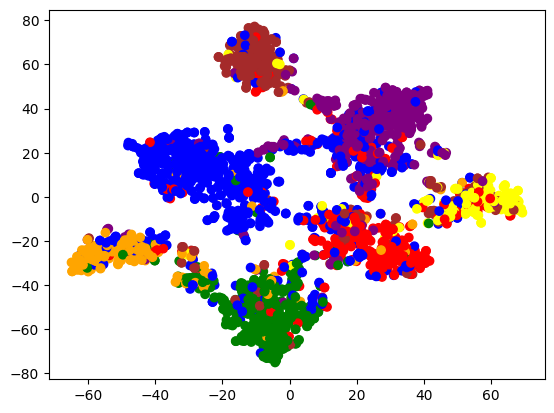

In [23]:
color_list = ["red", "orange", "green", "blue", "purple", "brown", "yellow"]

loader = DataLoader(dataset, batch_size=64, shuffle=True)
embs = []
colors = []
for batch in loader:
    # 모델을 통과시켜서 나온 결과를 볼 것
    emb, pred = model(batch)
    embs.append(emb)
    colors += [color_list[y] for y in batch.y]
embs = torch.cat(embs, dim=0)

xs, ys = zip(*TSNE().fit_transform(embs.detach().numpy()))
plt.scatter(xs, ys, color=colors)

-----------------------------------

In [24]:
class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.conv1 = pyg_nn.GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv2 = pyg_nn.GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

def train(epoch):
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    loss.backward()
    optimizer.step()
    
    writer.add_scalar("loss", loss.item(), epoch)

def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

dataset = Planetoid("/tmp/citeseer", "Citeseer", split='random', transform=T.NormalizeFeatures())
data = dataset[0]

channels = 16
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('CUDA availability:', torch.cuda.is_available())

# encoder: written by us; decoder: default (inner product)
# 점곱을 계산하는 GAE를 이용해서 앞에서 계산한 GCN을 통과시킨 것과 비교해봅니다.
model = pyg_nn.GAE(Encoder(dataset.num_features, channels)).to(dev)
labels = data.y
data.train_mask = data.val_mask = data.test_mask = data.y = None
data = pyg_utils.train_test_split_edges(data)
# 새로운 util인 https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/utils/train_test_split_edges.html
# train_test_split_edges 이용...
# 원래 (현재 작동하지 않는 코드)
# data = model.split_edges(data)
x, train_pos_edge_index = data.x.to(dev), data.train_pos_edge_index.to(dev)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1, 201):
    train(epoch)
    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    writer.add_scalar("AUC", auc, epoch)
    writer.add_scalar("AP", ap, epoch)
    if epoch % 10 == 0:
        print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

CUDA availability: True


c:\Users\yang.yoonjeong\anaconda3\envs\torch\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 010, AUC: 0.6539, AP: 0.7088
Epoch: 020, AUC: 0.7625, AP: 0.7627
Epoch: 030, AUC: 0.8048, AP: 0.7974
Epoch: 040, AUC: 0.8631, AP: 0.8578
Epoch: 050, AUC: 0.8720, AP: 0.8676
Epoch: 060, AUC: 0.8761, AP: 0.8709
Epoch: 070, AUC: 0.8911, AP: 0.8878
Epoch: 080, AUC: 0.8937, AP: 0.8893
Epoch: 090, AUC: 0.8903, AP: 0.8867
Epoch: 100, AUC: 0.8866, AP: 0.8822
Epoch: 110, AUC: 0.8843, AP: 0.8802
Epoch: 120, AUC: 0.8826, AP: 0.8801
Epoch: 130, AUC: 0.8816, AP: 0.8796
Epoch: 140, AUC: 0.8839, AP: 0.8809
Epoch: 150, AUC: 0.8905, AP: 0.8880
Epoch: 160, AUC: 0.8927, AP: 0.8897
Epoch: 170, AUC: 0.8908, AP: 0.8879
Epoch: 180, AUC: 0.8896, AP: 0.8875
Epoch: 190, AUC: 0.8871, AP: 0.8842
Epoch: 200, AUC: 0.8846, AP: 0.8840


c:\Users\yang.yoonjeong\anaconda3\envs\torch\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\yang.yoonjeong\anaconda3\envs\torch\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


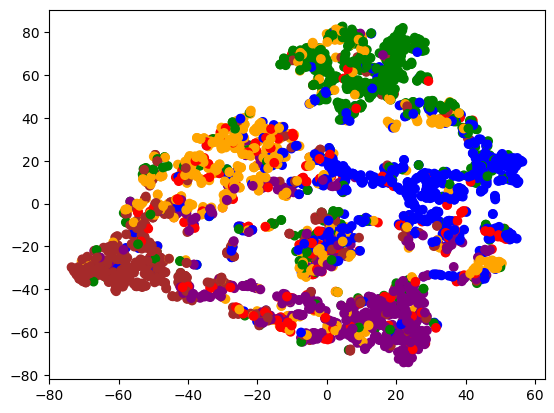

In [25]:
model.eval()
z = model.encode(x, train_pos_edge_index)
colors = [color_list[y] for y in labels]

xs, ys = zip(*TSNE().fit_transform(z.cpu().detach().numpy()))
plt.scatter(xs, ys, color=colors)
plt.show()